In [9]:
import numpy as np
V = (1/2)**2*np.pi
rho = 2700
m = V*rho
I = 1/2*m*(1/2)**2
print(I)

alpha = 1

tau = I*alpha

265.0718801466388


Planar Robot Experiment (Static Configuration)
Joint configuration (q) in radians: [0.  0.1 0.1]
Joint velocities (q_dot): [0 0 0]
Joint accelerations (q_ddot): [0 0 0]

C++ Torque Output:
  Joint 1:  0.000000
  Joint 2:  194.975996
  Joint 3: -0.488867

Robotics Toolbox Torque Output:
  Joint 1: -0.000000
  Joint 2:  194.975996
  Joint 3: -0.488867

Relative error (C++ vs Robotics Toolbox): 8.339181e-19


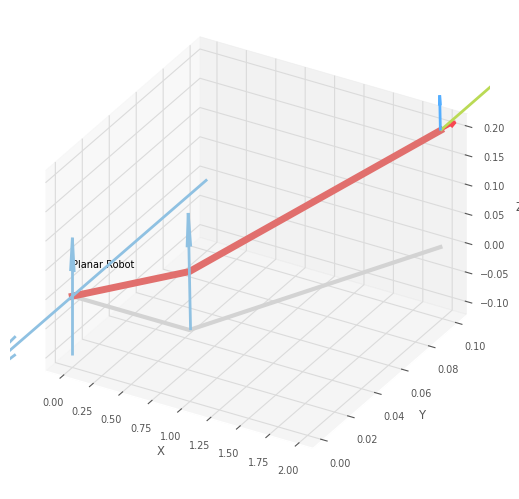

PyPlot3D backend, t = 0.05, scene:
  robot: Text(0.0, 0.0, 'Planar Robot')

<Figure size 640x480 with 0 Axes>

In [20]:
import sys
import os
import inspect
import numpy as np

# Path configuration: adjust this so that the C++ module is accessible.
current_dir = os.path.dirname(os.path.dirname(os.path.abspath(inspect.getsourcefile(lambda:0))))
module_path = os.path.join(current_dir, "robot_dynamics_module", "build", "Release")
sys.path.append(module_path)

import robot_dynamics_module.build.Release.compute_torque as compute_torque  # C++ module for torque computation

# ------------------------------
# Define the robot parameters (2-link robot)
# ------------------------------

# Each row of DH_params: [theta_offset, d, a, alpha]
DH_params = [
    [0.0, 0.0, 0.0, np.pi/2], 
    [0.0, 0.0, 1.0, -np.pi/2],
    [0.0, 0.0, 1.0, 0]
]

# Dynamic parameters:
# Masses: assume m1 and m2 (for a 2-link robot)
M = [0, 10, 10]

# Inertia matrices: for simplicity use diagonal matrices.
I1 = 0.0
I2 = 1.0
I3 = 1.0
InertiaMatrices = [
    np.diag([I1, I1, I1]),
    np.diag([I2, I2, I2]),
    np.diag([I3, I3, I3])
]

# Center of mass:
CenterOfMass = [
    [0, 0, 0],    # For Joint 1 (base)
    [-0.5, 0, 0],  # Link 2
    [-0.5, 0, 0]   # Link 3
]

# ------------------------------
# Define joint states (2 DOF)
# ------------------------------
# For plotting, we set a configuration. Here we choose the zero configuration.
q = np.array([0, 0.1, 0.1])
q_dot = np.array([0, 0, 0])      # rad/s
q_ddot = np.array([0, 0, 0])     # rad/s^2

# ------------------------------
# Compute joint torques using the C++ implementation
# ------------------------------
tau_cpp = compute_torque.computeJointTorques(
    q, q_dot, q_ddot, 
    M, InertiaMatrices, CenterOfMass, 
    np.array(DH_params)
)

# ------------------------------
# Compute joint torques using Peter Corke's Robotics Toolbox
# ------------------------------
def compute_torque_roboticstoolbox(q, q_dot, q_ddot, M, InertiaMatrices, CenterOfMass, DH_params):
    from roboticstoolbox import DHRobot, RevoluteDH
    n_dof = len(DH_params)
    links = []
    for i in range(n_dof):
        # Create each link using the DH parameters
        link = RevoluteDH(d=DH_params[i][1], a=DH_params[i][2], alpha=DH_params[i][3])
        # Set dynamic properties
        link.m = M[i]
        link.r = CenterOfMass[i]
        link.I = InertiaMatrices[i]
        links.append(link)
    robot = DHRobot(links)
    gravity = np.array([0, 0, -9.81])
    tau = robot.rne(q, q_dot, q_ddot, gravity)
    return tau

tau_rtb = compute_torque_roboticstoolbox(q, q_dot, q_ddot, M, InertiaMatrices, CenterOfMass, DH_params)

# ------------------------------
# Nicely print the torque results
# ------------------------------
def print_torques(label, tau):
    print(f"{label} Torque Output:")
    for i, t in enumerate(tau):
        print(f"  Joint {i+1}: {t: .6f}")
    print()

print("Planar Robot Experiment (Static Configuration)")
print("================================================")
print("Joint configuration (q) in radians:", q)
print("Joint velocities (q_dot):", q_dot)
print("Joint accelerations (q_ddot):", q_ddot)
print()

print_torques("C++", tau_cpp)
print_torques("Robotics Toolbox", tau_rtb)

norm_cpp = np.linalg.norm(tau_cpp) + 1e-12
rel_error_rtb = np.linalg.norm(tau_cpp - tau_rtb) / norm_cpp
print("Relative error (C++ vs Robotics Toolbox): {:.6e}".format(rel_error_rtb))


# ------------------------------
# Create and plot the robot using the Robotics Toolbox
# ------------------------------
from roboticstoolbox import DHRobot, RevoluteDH
links = []
for i in range(len(DH_params)):
    link = RevoluteDH(d=DH_params[i][1], a=DH_params[i][2], alpha=DH_params[i][3])
    # Set dynamic properties (optional for visualization)
    link.m = M[i]
    link.r = CenterOfMass[i]
    link.I = InertiaMatrices[i]
    links.append(link)

# Create the robot object with a given name
robot = DHRobot(links, name="Planar Robot")

# Plot the robot in the configuration defined by q
robot.plot(q)


In [11]:
import numpy as np
print(np.__version__)


1.26.4
